# **네거티브 샘플링을 이용한 Word2Vec 구현**
- 문제가 없는 부분은 그냥 돌려주시고, 문제가 있는 부분부터 푸시면 됩니다!
- 문제: q1 ~ q10

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# 20뉴스그룹 데이터를 사용
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [ ]:
news_df = pd.DataFrame({'document':documents})
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

<ipython-input-17-60647f39d4c7>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")


In [ ]:
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [ ]:
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
news_df['clean_doc']

0        well sure about story seem biased what disagre...
1        yeah expect people read actually accept hard a...
2        although realize that principle your strongest...
3        notwithstanding legitimate fuss about this pro...
4        well will have change scoring playoff pool unf...
                               ...                        
11308    sunroof leaks always thought those things were...
11309    danny rubenstein israeli journalist will speak...
11311    agree home runs clemens always memorable kinda...
11312    used deskjet with orange micros grappler syste...
11313    argument with murphy scared hell when came las...
Name: clean_doc, Length: 10995, dtype: object

In [ ]:
# 불용어를 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [ ]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [ ]:
vocab_size = len(word2idx) + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


In [ ]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [ ]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0],
          idx2word[pairs[i][1]], pairs[i][1],
          labels[i]))

(media (702), ubvms (21166)) -> 0
(makes (228), daniel (3358)) -> 0
(blessing (10669), vuurtoren (57671)) -> 0
(received (634), inhuman (10668)) -> 1
(atrocities (4406), degree (1530)) -> 1


In [ ]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

In [ ]:
# 네거티브 샘플링을 통한 데이터셋 구성하기

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [ ]:
# 네거티브 샘플링을 통한 데이터셋을 구성할 차례
# -> 네거티브 샘플링을 위해서 케라스에서 제공하는 전처리 도구인 skipgrams를 사용
# 어떤 전처리가 수행되는지 그 결과를 확인하기 위해서 상위 10개의 뉴스그룹 샘플에 대해서만 수행해보자!

embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embedding_dim)(c_inputs)

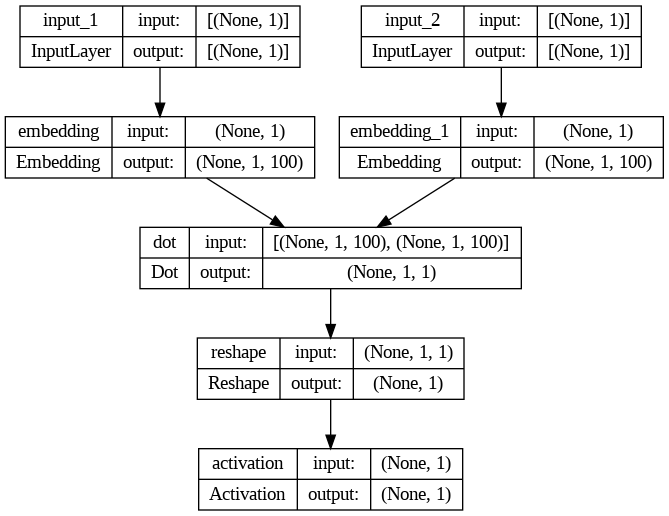

In [ ]:
# q1) 중심 단어의 임베딩과 주변 단어의 임베딩 간의 내적(dot product)를 계산해주세요 (1점)
dot_product = Dot(axes=2)([word_embedding, context_embedding])

# q2) dot_product의 차원을 재구성하여 (1,)의 형태로 만들어주세요 (1점)
dot_product = Reshape((1,))(dot_product)

# q3) 내적 값에 시그모이드 활성화 함수를 적용하세요 (1점)
output = Activation('sigmoid')(dot_product)

# q4) 모델을 정의하고 구조를 확인하세요 (1점)
model = Model(inputs=[w_inputs, c_inputs], outputs=output)

# q5) 손실 함수와 optimizer를 자유롭게 설정해주세요 (2점)
model.compile(loss='binary_crossentropy', optimizer='adam')

# q6) 모델의 구조를 시각화하고 'model.png' 파일로 저장하세요 (1점)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB')


In [ ]:
# q7) epoch 수를 원하는 만큼 지정해서 돌려주세요 (1점)
for epoch in range(1):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 0 Loss : 4626.411804951727


In [ ]:
import gensim

f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embedding_dim))
vectors = model.get_layer('embedding').get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [ ]:
# q8) 'knife'와 가장 유사한 단어들을 찾으세요 (1점)
w2v.most_similar(positive=['knife'])

[('assaulted', 0.8968901038169861),
 ('submarine', 0.8937344551086426),
 ('viewpoint', 0.8936426639556885),
 ('rebuild', 0.8912755250930786),
 ('continuation', 0.8910240530967712),
 ('rose', 0.8907821774482727),
 ('drilled', 0.8905319571495056),
 ('shafer', 0.8896981477737427),
 ('cages', 0.8893981575965881),
 ('luna', 0.8888663649559021)]

In [ ]:
# q9) 'engine'와 가장 유사한 단어들을 찾으세요 (1점)
w2v.most_similar(positive=['engine'])

[('lupica', 0.877363383769989),
 ('simpsons', 0.8718167543411255),
 ('untrue', 0.8694440722465515),
 ('turpin', 0.8659264445304871),
 ('crank', 0.865037739276886),
 ('faceoff', 0.8641482591629028),
 ('fusi', 0.8639191389083862),
 ('picked', 0.8635159134864807),
 ('obligation', 0.8628665804862976),
 ('closes', 0.8616696000099182)]

### skip-gram 모델 구현 문제입니다.

In [ ]:
import torch
import torch.nn as nn

In [ ]:
embedding_dim = 128
context_size = 4
epochs = 1000

example_sentence = """The iPhone 15 looks almost identical to previous models from a distance, but I immediately noticed some changes as soon as I picked one up.
The new phone is even lighter than the already airy iPhone 14, which combine with the freshly contoured edges and new matte finish for a device that just feels a bit nicer to have in your hand.
Each phone’s color (black, blue, green, yellow and pink) is now infused into the back glass this time around, which is designed to make each respective hue pop a bit more.
I found most of the options to be more subtle than saturated with color, though the pink model looked gorgeous in person.""".split()

#### context를 index vector로 전환해주는 작업입니다.

In [ ]:
def make_context_vector(context, word_to_ix):
  idxs = word_to_ix[context]
  return torch.tensor(idxs, dtype=torch.long)

#### 데이터셋을 만드는 함수 작업입니다.
##### data에는 context와 target에 대한 정보를 차례대로 넣어줍니다.
##### context는 현재 작업을 수행하는 단어 벡터 자체이고, target은 나중에 반환해줄 주변 단어들입니다.

In [ ]:
# make dataset function
def make_data(sentence):
  data = []
  for i in range(2, len(sentence) - 2):
    context = sentence[i]
    target = [sentence[i - 2], sentence[i - 1], sentence[i + 1], sentence[i + 2]]
    data.append((context, target))
  return data

#### 우리가 분석하길 원하는 예시 문장들의 단어를 Vocab으로 저장해 줍시다.

In [ ]:
vocab = set(example_sentence)
vocab_size = len(example_sentence)

#### word_to_index와 index_to_word는 나중에 훈련이나 추론 과정에서 각 단어별 인덱스를 부여하거나
#### 각 인덱스에 해당하는 단어를 탐색하는데 사용되는 정보용 dictionary 입니다.

In [ ]:
word_to_index = {word:index for index, word in enumerate(vocab)}
index_to_word = {index:word for index, word in enumerate(vocab)}

In [ ]:
data = make_data(example_sentence)

#### skip-gram의 모델을 작성해봅시다.
#### hidden layer와 ouputlayer의 foward 부분을 작성해봅시다.
#### embedding vector를 바탕을 연산을 해서 hidden layer로 (선형 -> 활성화),
#### hidden layer의 결과에 연산을 해서 ouput으로 출력해줍니다 (선형 -> 활성화).
#### 마지막 return 내에는 출력에 원하는 단어 형태에 맞춰 반환해 준 것입니다.
<img src="https://i.imgur.com/c4sUimp.png" width = "400" />

In [ ]:
class SKIP_GRAM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, context_size):
    super(SKIP_GRAM, self).__init__()
    self.context_size = context_size
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    self.layer1 = nn.Linear(embedding_dim, 64)
    self.activation1 = nn.ReLU()

    self.layer2 = nn.Linear(64, vocab_size * context_size)
    self.activation2 = nn.LogSoftmax(dim = -1)

  def forward(self, inputs):
    embeded_vector = self.embeddings(inputs)
    output = self.activation1(self.layer1(embeded_vector))
    output = self.activation2(self.layer2(output))
    return output.view(self.context_size,vocab_size)

#### NLLoss는 log-likelihood를 위한 loss입니다.

In [ ]:
model = SKIP_GRAM(vocab_size, embedding_dim , context_size)
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

#### train을 담당하는 부분입니다.

In [ ]:
for epoch in range(epochs):
    total_loss = 0
    for context, target in data:
        context_vector = make_context_vector(context, word_to_index)
        log_probs = model(context_vector)
        total_loss += loss_function(log_probs, torch.tensor([word_to_index[t] for t in target]))
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    print(f'epoch = {epoch}, loss =  {total_loss}')

epoch = 0, loss =  681.6369018554688
epoch = 1, loss =  680.7319946289062
epoch = 2, loss =  679.8361206054688
epoch = 3, loss =  678.9465942382812
epoch = 4, loss =  678.0612182617188
epoch = 5, loss =  677.184814453125
epoch = 6, loss =  676.31298828125
epoch = 7, loss =  675.444091796875
epoch = 8, loss =  674.5802612304688
epoch = 9, loss =  673.7265625
epoch = 10, loss =  672.87939453125
epoch = 11, loss =  672.0400390625
epoch = 12, loss =  671.2077026367188
epoch = 13, loss =  670.3804321289062
epoch = 14, loss =  669.5570068359375
epoch = 15, loss =  668.7366943359375
epoch = 16, loss =  667.9191284179688
epoch = 17, loss =  667.1062622070312
epoch = 18, loss =  666.29052734375
epoch = 19, loss =  665.4711303710938
epoch = 20, loss =  664.6563720703125
epoch = 21, loss =  663.843994140625
epoch = 22, loss =  663.0418701171875
epoch = 23, loss =  662.2428588867188
epoch = 24, loss =  661.4466552734375
epoch = 25, loss =  660.6519775390625
epoch = 26, loss =  659.8582153320312
ep

#### 위의 train code를 바탕으로 아래 빈칸을 채워봅시다.

In [ ]:
test_data = 'iPhone'
test_vector = make_context_vector(test_data, word_to_index)
result = model(test_vector)
print('Prediction : ', [index_to_word[torch.argmax(r).item()] for r in result])

Prediction :  ['already', 'airy', '14,', 'which']


#### model 예측하기.

In [ ]:
test_data1 = 'model'
test_vector1 = make_context_vector(test_data1, word_to_index)
result1 = model(test_vector1)
print([index_to_word[torch.argmax(r).item()] for r in result1])

['the', 'pink', 'looked', 'gorgeous']


### skip-gram 모델 구현 문제입니다.

In [ ]:
import torch
import torch.nn as nn

In [ ]:
embedding_dim = 128
context_size = 4
epochs = 1000

example_sentence = """The iPhone 15 looks almost identical to previous models from a distance, but I immediately noticed some changes as soon as I picked one up.
The new phone is even lighter than the already airy iPhone 14, which combine with the freshly contoured edges and new matte finish for a device that just feels a bit nicer to have in your hand.
Each phone’s color (black, blue, green, yellow and pink) is now infused into the back glass this time around, which is designed to make each respective hue pop a bit more.
I found most of the options to be more subtle than saturated with color, though the pink model looked gorgeous in person.""".split()

#### context를 index vector로 전환해주는 작업입니다.

In [ ]:
def make_context_vector(context, word_to_ix):
  idxs = word_to_ix[context]
  return torch.tensor(idxs, dtype=torch.long)

#### 데이터셋을 만드는 함수 작업입니다.
##### data에는 context와 target에 대한 정보를 차례대로 넣어줍니다.
##### context는 현재 작업을 수행하는 단어 벡터 자체이고, target은 나중에 반환해줄 주변 단어들입니다.
##### target 부분을 채워 봅시다. target에는 context 단어를 기준으로 앞에 두 단어, 뒤에 두 단어가 들어가도록 세팅해줍시다. (2점)

In [ ]:
# make dataset function
def make_data(sentence):
    data = []
    for i in range(2, len(sentence) - 2):
        context = sentence[i]
        # 주변 단어들을 target에 추가
        target = [sentence[i-2], sentence[i-1], sentence[i+1], sentence[i+2]]
        data.append((context, target))
    return data

#### 우리가 분석하길 원하는 예시 문장들의 단어를 Vocab으로 저장해 줍시다.

In [ ]:
vocab = set(example_sentence)
vocab_size = len(example_sentence)

#### word_to_index와 index_to_word는 나중에 훈련이나 추론 과정에서 각 단어별 인덱스를 부여하거나
#### 각 인덱스에 해당하는 단어를 탐색하는데 사용되는 정보용 dictionary 입니다.

In [ ]:
word_to_index = {word:index for index, word in enumerate(vocab)}
index_to_word = {index:word for index, word in enumerate(vocab)}

#### 앞서 미리 정의해둔 make_data 함수에 우리가 원하는 문장 예제를 넣어 학습할 데이터를 만들어 봅시다. (1점)

In [ ]:
data = make_data(example_sentence)

#### skip-gram의 모델을 작성해봅시다.
#### hidden layer와 ouputlayer의 foward 부분을 작성해봅시다.
#### embedding vector를 바탕을 연산을 해서 hidden layer로 (선형 -> 활성화), (1.5점)
#### hidden layer의 결과에 연산을 해서 ouput으로 출력해줍니다 (선형 -> 활성화). (1.5점)
#### 마지막 return 내에는 출력에 원하는 단어 형태에 맞춰 반환해 준 것입니다.
<img src="https://i.imgur.com/c4sUimp.png" width = "400" />

In [ ]:
class SKIP_GRAM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, context_size):
    super(SKIP_GRAM, self).__init__()
    self.context_size = context_size
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    self.layer1 = nn.Linear(embedding_dim, 64)
    self.activation1 = nn.ReLU()

    self.layer2 = nn.Linear(64, vocab_size * context_size)
    self.activation2 = nn.LogSoftmax(dim = -1)

  def forward(self, inputs):
    embeded_vector = self.embeddings(inputs)
    output = self.activation1(self.layer1(embeded_vector))
    output = self.activation2(self.layer2(output))
    return output.view(self.context_size, vocab_size)


#### NLLoss는 log-likelihood를 위한 loss입니다.

In [ ]:
model = SKIP_GRAM(vocab_size, embedding_dim , context_size)
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

#### train을 담당하는 부분입니다.

In [ ]:
for epoch in range(epochs):
    total_loss = 0
    for context, target in data:
        context_vector = make_context_vector(context, word_to_index)
        log_probs = model(context_vector)
        total_loss += loss_function(log_probs, torch.tensor([word_to_index[t] for t in target]))
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    print(f'epoch = {epoch}, loss =  {total_loss}')

epoch = 0, loss =  683.03466796875
epoch = 1, loss =  682.1970825195312
epoch = 2, loss =  681.365478515625
epoch = 3, loss =  680.5401000976562
epoch = 4, loss =  679.7222290039062
epoch = 5, loss =  678.9151611328125
epoch = 6, loss =  678.1101684570312
epoch = 7, loss =  677.30810546875
epoch = 8, loss =  676.5086669921875
epoch = 9, loss =  675.7154541015625
epoch = 10, loss =  674.9249267578125
epoch = 11, loss =  674.1386108398438
epoch = 12, loss =  673.3585205078125
epoch = 13, loss =  672.5853271484375
epoch = 14, loss =  671.81494140625
epoch = 15, loss =  671.046875
epoch = 16, loss =  670.2808837890625
epoch = 17, loss =  669.516845703125
epoch = 18, loss =  668.7579956054688
epoch = 19, loss =  668.0006713867188
epoch = 20, loss =  667.2454223632812
epoch = 21, loss =  666.4948120117188
epoch = 22, loss =  665.7467651367188
epoch = 23, loss =  664.9993896484375
epoch = 24, loss =  664.252197265625
epoch = 25, loss =  663.5043334960938
epoch = 26, loss =  662.7589721679688


#### 위의 train code를 바탕으로 아래 빈칸을 채워봅시다. (2점)

In [ ]:
test_data = 'CBOW'
test_vector = make_context_vector(test_data, word_to_index)
result = model(test_vector)
print('Prediction : ', [index_to_word[torch.argmax(r).item()] for r in result])


#### 위의 test code를 바탕으로 'model' 단어 주변에 올 단어를 예측해봅시다. (2점)

In [ ]:

# 자유롭게 작성해봐요.

In [ ]:
test_data = 'model'

test_vector = make_context_vector(test_data, word_to_index)
result = model(test_vector)
print('Prediction : ', [index_to_word[torch.argmax(r).item()] for r in result])


Prediction :  ['the', 'pink', 'looked', 'gorgeous']


In [ ]:
context

'gorgeous'